In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd
import json
from shapely.geometry import Point, LineString, MultiLineString


In [16]:
gdf = gpd.read_file("../geojson/hanoi_metro/hanoi_metro_lines.geojson", crs="EPSG:3857")
gdf = gdf.to_crs("epsg:4326")
gdf['globeid'] = gdf['GlobalID']
gdf['GlobalID'] = gdf['TITLE']
gdf['TITLE'] = gdf["TITLE"].str.replace("'", "")
df = gdf.groupby('TITLE').agg({
    'OBJECTID': 'first',
    'VISIBLE': 'first',
    'DESCRIPTION': 'first',
    'IMAGE_URL': 'first',
    'IMAGE_LINK_URL': 'first',
    'DATE': 'first',
    'TYPEID': 'first',
    'GlobalID': 'first',
    'geometry': lambda x: x.union_all(),
    'globeid': 'first'
}).reset_index()
#df.head(20)
gdf = gpd.GeoDataFrame(df, crs="epsg:4326")

def multiline_to_single_line(geometry) -> LineString:
  if isinstance(geometry, LineString):
      return geometry
  coords = list(map(lambda part: list(part.coords), geometry.geoms))
  flat_coords = [Point(*point) for segment in coords for point in segment]
  return LineString(flat_coords)

gdf.loc[3, 'geometry'] =  multiline_to_single_line(gdf.loc[3, 'geometry'])
try:
    os.remove("../geojson/hanoi_metro/hanoi_metro_lines_c.geojson")
    gdf.to_file("../geojson/hanoi_metro/hanoi_metro_lines_c.geojson")
except OSError:
    gdf.to_file("../geojson/hanoi_metro/hanoi_metro_lines_c.geojson")
gdf.head(20)

/Users/minhnguyen/miniconda3/envs/manim2023/lib/python3.10/site-packages/pyogrio/raw.py:196: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(


,TITLE,OBJECTID,VISIBLE,DESCRIPTION,IMAGE_URL,IMAGE_LINK_URL,DATE,TYPEID,GlobalID,geometry,globeid
0,2A Line,1,1,None,None,None,None,0,2A Line,"LINESTRING (105.8273 21.029, 105.82746 21.0269...",a892b0d9-5442-4058-a88b-b55f5e565457
1,Line 1,2,1,None,None,None,None,0,Line 1,"MULTILINESTRING ((105.93085 21.10069, 105.9157...",9290dd14-1cc9-4223-9225-313245545983
2,Line 2,4,1,None,None,None,None,0,Line 2,"MULTILINESTRING ((105.84803 21.25658, 105.8420...",aa39c8c8-414b-4db9-ac43-48aa2103d153
3,Line 3,6,1,None,None,None,None,0,Line 3,"LINESTRING (105.68899 21.07967, 105.69508 21.0...",d70e92a9-42ff-46ca-9e90-6db6242f82da
4,Line 3 future,13,1,None,None,None,None,0,Line 3 future,"MULTILINESTRING ((105.84642 21.0227, 105.85895...",a9882613-90be-4e4e-8f0c-21bcee9b280f
5,Line 3-uc,24,1,None,None,None,None,0,Line 3-uc,"MULTILINESTRING ((105.68899 21.07967, 105.6950...",c4a0b80c-ec0d-4abb-a6fc-f66c5e9ee472
6,Line 4,16,1,None,None,None,None,0,Line 4,"LINESTRING (105.70574 21.09537, 105.71278 21.0...",5dcee158-1595-4578-a81d-52fee85f741e
7,Line 5,17,1,None,None,None,None,0,Line 5,"MULTILINESTRING ((105.81682 21.04283, 105.8125...",8d34be2d-84eb-4b6e-975c-20245a026872
8,Line 6,19,1,None,None,None,None,0,Line 6,"MULTILINESTRING ((105.80075 21.2145, 105.78213...",101d9ae6-7d0a-49c0-9458-8d3dba29731d
9,Line 7,21,1,None,None,None,None,0,Line 7,"LINESTRING (105.75923 21.16905, 105.76094 21.1...",8f987cec-8c94-4e4f-8798-f7859d007485


<Axes: >

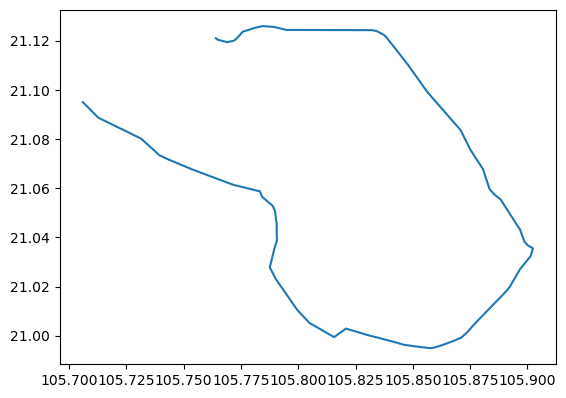

In [26]:
gdf[gdf['TITLE']=='Line 4'].plot()

In [19]:
with open('./all_stations.json', 'r') as file:
    data = json.load(file)

def flatten_features(features):
    flattened_data = []
    for feature in features:
        flattened_feature = {
            "x": feature["geometry"]["x"],
            "y": feature["geometry"]["y"],
            "spatialReferenceWkid": feature["geometry"]["spatialReference"]["wkid"],
            "order": feature["attributes"]["Order_"],
            "station": feature["attributes"]["Station"],
            "line": feature["attributes"]["Line"],
            "long": feature["attributes"]["Long"],
            "lat": feature["attributes"]["Lat"],
            "objectId": feature["attributes"]["__OBJECTID"]
        }
        flattened_data.append(flattened_feature)
    return flattened_data
flattened_features = flatten_features(data["features"])
bdf = pd.DataFrame(flattened_features).sort_values(by="objectId")
bdf['geometry'] = bdf.apply(lambda row: Point(row['long'], row['lat']), axis=1)
bdf = gpd.GeoDataFrame(bdf, geometry="geometry", crs="epsg:4326")
bdf.to_file("../geojson/hanoi_metro/hanoi_all_stations.geojson")
bdf.head()

/Users/minhnguyen/miniconda3/envs/manim2023/lib/python3.10/site-packages/pyogrio/raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(


,x,y,spatialReferenceWkid,order,station,line,long,lat,objectId,geometry
0,11780645.16,2395257.55,102100,1,Cat Linh,2A,105.827336,21.028335,0,POINT (105.82734 21.02833)
2,11780422.18,2394284.40,102100,2,La Thanh,2A,105.825333,21.020175,1,POINT (105.82533 21.02017)
3,11779764.40,2393619.33,102100,3,Thai Ha,2A,105.819424,21.014598,2,POINT (105.81942 21.0146)
4,11779385.69,2392654.73,102100,5,Lang,2A,105.816022,21.006509,3,POINT (105.81602 21.00651)
5,11778971.47,2391609.82,102100,6,Thuong Dinh,2A,105.812301,20.997746,4,POINT (105.8123 20.99775)


In [21]:
bdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 177 entries, 0 to 1
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   x                     177 non-null    float64 
 1   y                     177 non-null    float64 
 2   spatialReferenceWkid  177 non-null    int64   
 3   order                 177 non-null    int64   
 4   station               177 non-null    object  
 5   line                  177 non-null    object  
 6   long                  177 non-null    float64 
 7   lat                   177 non-null    float64 
 8   objectId              177 non-null    int64   
 9   geometry              177 non-null    geometry
dtypes: float64(4), geometry(1), int64(3), object(2)
memory usage: 15.2+ KB


In [ ]:
    #line_name = f"Line {df['line'].iloc[0]}"
    #geojson_data = {
    #"type": "FeatureCollection",
    #"name": line_name,
    #line_name: []
    #}
    #for idx, row in gdf.iterrows():
    #    feature = {
    #        "type": "Features",
    #        "properties": {
    #            "x": row['x'],
    #            "y": row['y'],
    #            "spatialReferenceWkid": row['spatialReferenceWkid'],
    #            "order": row['order'],
    #            "station": row['station'],
    #            "line": row['line'],
    #            "long": row['long'],
    #            "lat": row['lat'],
    #            "objectId": row['objectId'],
    #            "GlobalID": row['GlobalID']
    #        },
    #        "geometry": {
    #            "type": "Point",
    #            "coordinates": [row['long'], row['lat']]
    #        }
    #    }
    #    geojson_data[line_name].append(feature)
    #parsed_json = json.loads(geojson_data)

In [ ]:
dfs = [df for _, df in bdf.groupby("line")]
def export_geojson(gdf, path):
    try:
        os.remove(path)
        gdf.to_file(path, driver="geojson")
    except OSError:
        gdf.to_file(path, driver="geojson")
#dfs[0].head()
for df in dfs:
    df['geometry'] = df.apply(lambda row: Point(row['long'], row['lat']), axis=1)
    df['GlobalID'] = df['station']
    gdf = gpd.GeoDataFrame(df, geometry="geometry", crs='epsg:4326')
    path = f"./geojson/line_{df['line'].iloc[0]}_stations.geojson"
    #with open(path, 'w') as f:
    #    json.dump(geojson_data, f, indent=2)
    export_geojson(gdf, path)

c:\Users\Admin\miniconda3\envs\data_1\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\data_1\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\data_1\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\data_1\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\data_1\Lib\site-packages\pyog